In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
N = 200 # number of points
n = 100 # number of samples/observations
p = 5 # number of variables/features

C = np.random.randint(0, 2, size=(p,p))
r = np.random.multivariate_normal(np.zeros(p), C @ C.T, size=(N, n))

t = np.linspace(0, 1, N)
x = np.cumsum((1/np.sqrt(N))*r, axis=0)

mu = np.mean(x, axis=1, keepdims=True)
x = x - mu

In [3]:
# Generate data
a = 20*t[:, np.newaxis, np.newaxis] + 2*np.random.random((1,n,1)) + 3*np.arange(p)[np.newaxis, np.newaxis, :]
x = (1+np.arange(p)[np.newaxis, np.newaxis, :])*np.sin(a)/2

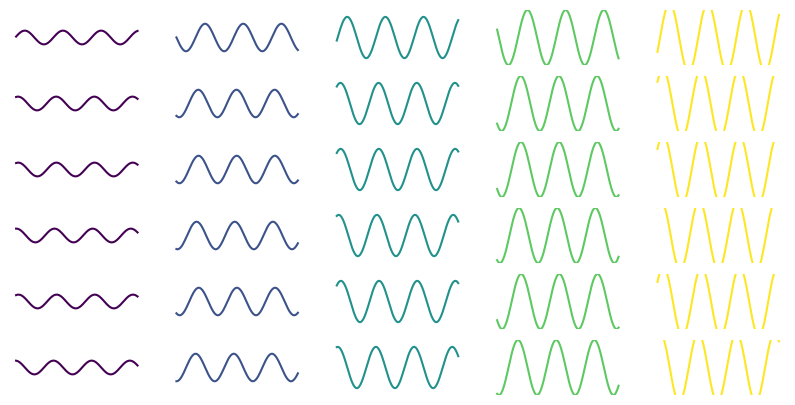

In [4]:
# plot a sample of 6 observations of the first 3 variables
fig, axs = plt.subplots(6, 5, figsize=(10, 5))
cmap = matplotlib.colormaps['viridis'].resampled(5)
for i in range(6):
    for j in range(5):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j))
        ax.set_axis_off()
        ax.set_ylim((-2,2))

In [5]:
# Calculate $\hat{X}$ and its covariance statistic
x_hat = np.fft.fft(x, axis=0)
cov_hat = (x_hat.transpose(0,2,1) @ np.conjugate(x_hat)) / (n-1)

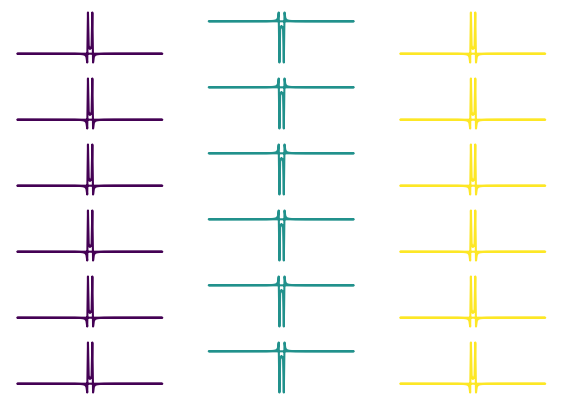

In [12]:
# plot a sample of 6 observations of the first 3 variables
freq = np.fft.fftfreq(N)
fig, axs = plt.subplots(6, 3, figsize=(7, 5))
cmap = matplotlib.colormaps['viridis'].resampled(3)
for i in range(6):
    for j in range(3):
        ax = axs[i,j]
        ax.plot(freq, x_hat[:, i,j].real, c=cmap(j))
        ax.set_axis_off()
        #ax.set_ylim((0,2))

In [28]:
# Calculate the eigenvalues and eigenvectors of the covariance in the Fourier domain and order by descending order
eval_hat, evec_hat = np.linalg.eigh(cov_hat)

idx = np.argsort(eval_hat, axis=1)[:, ::-1]
eval_hat = np.take_along_axis(eval_hat, idx, axis=-1)
evec_hat = np.take_along_axis(evec_hat, idx[:,np.newaxis,:], axis=-1)

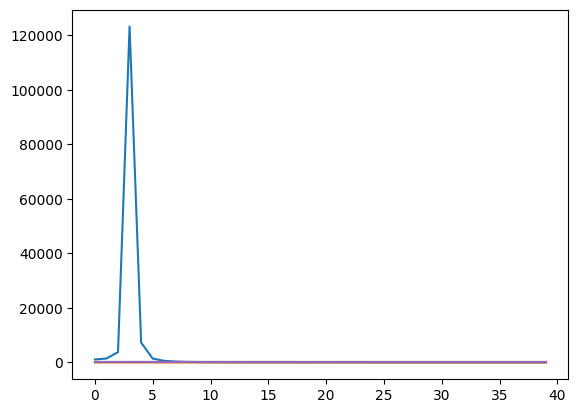

In [29]:
plt.plot(eval_hat[:40])
plt.show()

In [30]:
# select correctly the sign of the eigenvectors
#for i in range(1, eigenvectors.shape[0]):
#    eigenvectors[i] *= np.sign(np.sum(eigenvectors[i] * eigenvectors[i-1], axis=0, keepdims=True))

# Method I
It is the more costly bust straightforward. We just need to calculate:
$$
Y(t) = (\Psi^* \circ \Psi) (X(t))
$$
It can be written in the matrix form as
$$
Y(t) = V(t) \ast V(t)^\dagger \ast X(t)
$$

In [31]:
evec = np.fft.ifft(evec_hat, axis=0)
evec_conjugate = np.fft.ifft(evec_hat.conjugate(), axis=0)

In [32]:
k=1

x_complex = x.astype(np.complex128)
Z = np.zeros((N+N-1, n, k), dtype=np.complex128)
for _n in range(n):
    for _p in range(p):
        for _k in range(k):
            Z[:, _n, _k] +=np.convolve(x_complex[:, _n, _p], evec_conjugate[:, _p, _k], mode="full")

In [33]:
y = np.zeros((N+N+N-2, n, p), dtype=np.complex128)
for _n in range(n):
    for _p in range(p):
        for _k in range(k):
            y[:, _n, _p] += np.convolve(Z[:, _n, _k], evec[:, _p, _k], mode="full")

y = y[:N]

In [34]:
print("Mean Square Error in real domain: ", np.mean(np.square(np.absolute(y - x))))

Mean Square Error in real domain:  0.07274283447880732


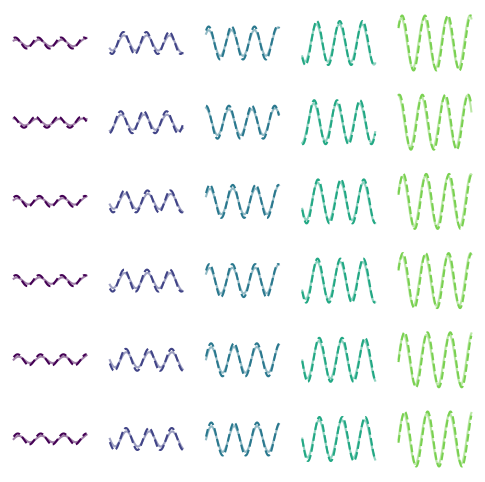

In [35]:
# plot a sample of n_r observations of the first n_c variables
n_r, n_c = 6, 5
fig, axs = plt.subplots(n_r, n_c, figsize=(6, 6))
cmap = matplotlib.colormaps['viridis'].resampled(n_c+1)
for i in range(n_r):
    for j in range(n_c):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j), linestyle='dashed')
        ax.plot(t, y[:, i,j], c=cmap(j), alpha=0.5)
        ax.set_axis_off()
        ax.set_ylim((-3,3))

# Method 2
Calculate the long but efficient way:
$$
Y(t) = (\mathcal{F}^{-1} \circ \Phi^*(\cdot, \widehat{V}(\xi)) \circ \Phi(\cdot, \widehat{V}(\xi)) \circ \mathcal{F}) (X(t))
$$
In other words, the operations in matrix in the Fourier space look like
$$
\widehat{Y}(\xi) = V(t)V(t)^\dagger \widehat{X}(\xi)
$$

In [36]:
k=1

Z = x_hat @ evec_hat[:, :, :k].conjugate()
y_hat = Z @ evec_hat[:, :, :k].transpose(0,2,1)

y = np.fft.ifft(y_hat, axis=0)

In [37]:
print("Mean Square Error in Fourier domain: ", np.mean(np.square(np.absolute(x_hat - y_hat))))
print("Mean Square Error in Real domain: ", np.mean(np.square(np.absolute(x - y))))

Mean Square Error in Fourier domain:  0.15343538630921472
Mean Square Error in Real domain:  0.0007671769315460734


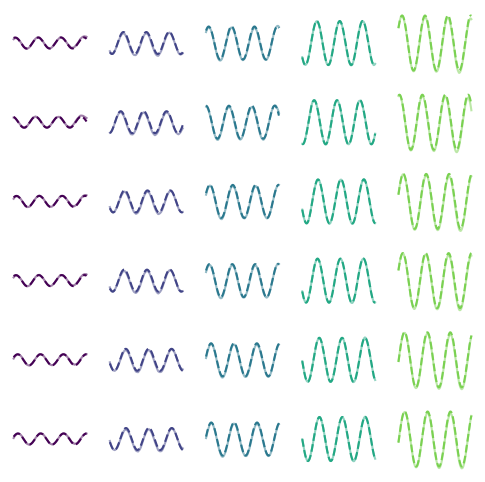

In [38]:
# plot a sample of n_r observations of the first n_c variables
n_r, n_c = 6, 5
fig, axs = plt.subplots(n_r, n_c, figsize=(6,6))
cmap = matplotlib.colormaps['viridis'].resampled(n_c+1)
for i in range(n_r):
    for j in range(n_c):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j), linestyle='dashed')
        ax.plot(t, y[:, i,j].real + mu[:, 0, j], c=cmap(j), alpha=0.5)
        ax.set_axis_off()
        ax.set_ylim((-3,3))